In [ ]:
# Enable TensorFlow to use GPU in Colab
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from matplotlib.pyplot import imshow

In [ ]:

# Load label data
train_class = pd.read_csv('/content/drive/MyDrive/train/org___classes.csv')
test_class = pd.read_csv('/content/drive/MyDrive/MajorProject/test/_classes.csv')
valid_class = pd.read_csv('/content/drive/MyDrive/MajorProject/valid/_classes .csv')

In [ ]:



test_class[test_class['filename']=='org_Copy-of-mild-ventriculomegaly-18c_aug_2_png_jpg.jpg'[4:]]

,filename,anold-chiari-malformation,arachnoid-cyst,cerebellah-hypoplasia,colphocephaly,encephalocele,holoprosencephaly,hydracenphaly,intracranial-hemorrdge,intracranial-tumor,m-magna,mild-ventriculomegaly,moderate-ventriculomegaly,normal,polencephaly,severe-ventriculomegaly,vein-of-galen


In [ ]:
# Load images and preprocess them
def load_images_and_labels(img_dir, class_df):
    images, labels = [], []
    for img_name in os.listdir(img_dir):
        # print(img_name)
        row = class_df[class_df['filename'] == img_name[5:]]

        images.append(cv2.resize(cv2.imread(os.path.join(img_dir, img_name)), (224, 224)))
        labels.append(row.values[0][1:])

    return np.array(images) / 255.0, np.array(labels)

In [ ]:
train_images, train_labels = load_images_and_labels('/content/drive/MyDrive/MajorProject/shuffled_train', train_class)


In [ ]:
len(train_images)

3000

In [ ]:
test_images, test_labels = load_images_and_labels('/content/drive/MyDrive/MajorProject/clahe_test', test_class)


In [ ]:

valid_images, valid_labels = load_images_and_labels('/content/drive/MyDrive/MajorProject/clahe_valid', valid_class)

In [ ]:
def identity_block(X, f, filters, stage, block):
    """

    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Saving the input value.we need this later to add to the output.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    # First layer
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)


    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3), classes=16):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)


    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')


    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')



    ### START CODE HERE ###

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers


model = ResNet50(input_shape=(224, 224, 3), classes=16)
#     # Apply L2 regularization to all Dense layers
# for layer in model.layers:
#   if isinstance(layer, tf.keras.layers.Dense) or isinstance(layer, tf.keras.layers.Conv2D):
#       layer.kernel_regularizer = regularizers.l2(0.5) # The 0.001 is the value of lamda
# # model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:loc

In [ ]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localh

In [ ]:
# print(train_images.dtype)  # check column types in your input data
train_labels=train_labels.astype('float64')

In [ ]:
test_labels=test_labels.astype('float64')

In [ ]:
train_labels.shape

(3000, 16)

In [ ]:
train_images.shape

(3000, 224, 224, 3)

In [ ]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9  # Decay the learning rate by 10% after 5 epochs

lr_scheduler = LearningRateScheduler(scheduler)


history=model.fit(train_images, train_labels, epochs=23, validation_data=(test_images, test_labels),callbacks=[lr_scheduler])

Streaming output truncated to the last 5000 lines.
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
43/94 ━━━━━━━━━━━━━━━━━━━━ 16s 330ms/step - accuracy: 0.9974 - loss: 0.0073Executing op __inference_multi_step_on_iterator_44466 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:

In [ ]:
model.summary()


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 64)   │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 112, 112, 64)   │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 55, 55, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2a (Conv2D)   │ (None, 55, 55, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2a             │ (None, 55, 55, 64)     │            256 │ res2a_branch2a[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 55, 55, 64)     │              0 │ bn2a_branch2a[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2b (Conv2D)   │ (None, 55, 55, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2b             │ (None, 55, 55, 64)     │            256 │ res2a_branch2b[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 55, 55, 64)     │              0 │ bn2a_branch2b[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2c (Conv2D)   │ (None, 55, 55, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch1 (Conv2D)    │ (None, 55, 55, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2c             │ (None, 55, 55, 256)    │          1,024 │ res2a_branch2c[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch1              │ (None, 55, 55, 256)    │          1,024 │ res2a_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 71,541,682 (272.91 MB)

 Trainable params: 23,829,520 (90.90 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,659,042 (181.80 MB)

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/model_23.h5')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:loca

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [ ]:
preds = model.evaluate(test_images, test_labels)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pr

In [ ]:
preds

[1.7339301109313965, 0.5625]

In [ ]:
y_pred=model.predict(test_images)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
y_actual=np.argmax(test_labels,axis=1)

In [ ]:
y_actual

array([10,  7, 13, 11, 12, 14, 12,  2,  4,  4,  3, 10,  2,  2, 10, 10, 14,
        2,  6, 14, 11,  3,  5, 12,  2, 11,  7,  3, 12, 10, 12, 13, 12, 14,
       11, 12,  7, 14, 11, 12, 10, 11, 10, 12,  1, 11,  1, 11, 11, 11, 14,
        4, 11,  1,  4,  3, 14, 13,  4, 13, 10, 10, 10, 11, 10,  4, 11,  3,
       10,  0, 10,  4, 12,  3,  2,  7, 12, 11,  2, 11, 10, 12,  0,  2, 14,
        1,  5, 10,  4,  1, 10, 11,  2,  4, 12, 10,  9, 10,  2, 11,  1,  3,
       12, 12, 14,  7,  2, 10,  2,  1,  4, 14,  4, 14, 11,  1, 14, 14, 12,
        4, 11, 14,  5, 12,  4, 10,  9,  7, 14,  4, 12,  2, 13, 11, 14, 11,
       10,  1, 12, 11,  3, 10,  1, 11,  1,  3, 11, 14,  3, 10,  4,  1,  7,
       13, 11, 14,  2,  0, 12,  5, 12,  2,  3, 12,  2,  9, 10, 14, 13,  7,
       12,  9, 11,  1, 12,  6])

In [ ]:
y_pred

array([10,  7, 13, 11, 12, 14, 12, 11,  4,  4, 12, 10,  2,  2, 10, 10, 14,
        1,  8, 14, 11,  3, 14, 12,  2, 10,  7, 11, 12,  0, 12, 13, 12,  2,
       11, 12,  7, 14, 11, 12, 12,  2, 11, 12,  1, 11,  1, 11, 11, 12, 13,
        4, 11,  1,  4, 11, 14, 13,  4, 13, 10, 10,  4, 10, 14,  4, 11,  3,
       10,  0, 10,  4, 12,  3,  6,  7, 12, 11,  2, 11, 10, 12,  0,  2, 14,
        1, 10, 10,  4,  1, 10, 11,  2,  4, 12, 10,  9, 10,  4, 11,  1,  2,
       12, 12, 14,  7,  2, 10, 10,  1,  4, 14, 10, 14, 11,  1, 14, 14, 12,
        4,  2, 11,  5, 12,  4, 11, 13,  7, 14,  4, 12,  2, 13, 11, 14, 11,
       10,  1, 12, 11,  2, 10,  1, 11,  1,  3, 11, 10,  2, 10,  4,  1,  7,
       13, 11, 14,  2, 14, 12, 10, 12,  2,  3, 11,  2,  9, 10, 14, 13, 10,
       12,  9, 11, 11, 10,  6])

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
accuracy_score(y_actual,y_pred)

0.7443181818181818

In [ ]:
def new_data_prediction(img):
  # Resize the image to the correct input shape for the model
  img = cv2.resize(img, (224, 224))  # Resize to (224, 224)
  # Add a batch dimension to the image
  img = img.reshape(1, 224, 224, 3)
  # Preprocess image as per model requirements
  img = img / 255.0  # Assuming your preprocessing for training included dividing by 255
  # Make the prediction
  prediction = model.predict(img)
  return np.argmax(model.predict(img))



In [ ]:
from tensorflow.keras.models import load_model,save_model
model.save("model_23.h5",save_format='h5')

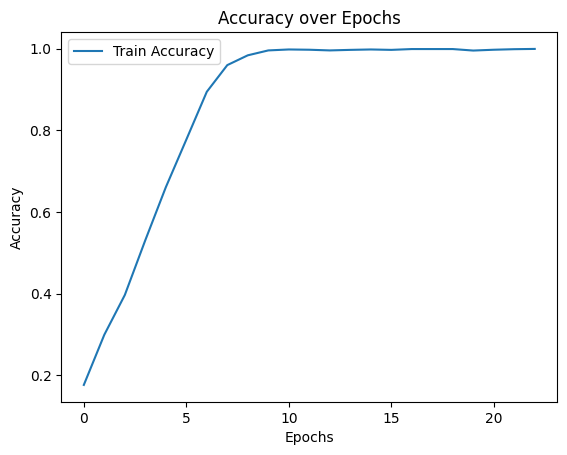

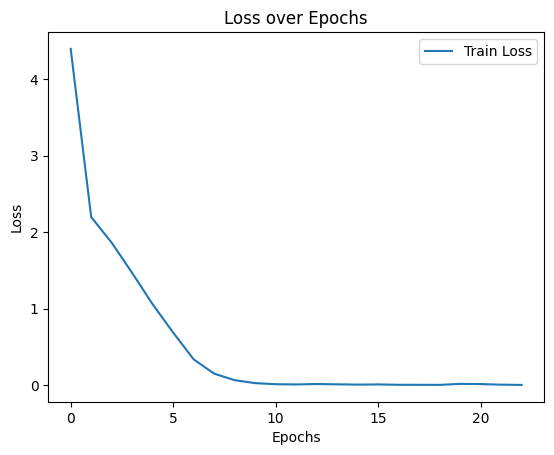

In [ ]:
import matplotlib.pyplot as plt

# Extract history

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


[1,2,3,4]


[1, 2, 3, 4]
